In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.regularizers import Regularizer
from keras import backend as K

In [ ]:
# this is the size of our encoded representations
encoding_dim = 30  # 30 floats -> compression of factor 2.13, assuming the input is 64 floats
epochs = 500

In [ ]:
# p * log(p / p_hat) + (1-p) * log( (1-p) / (1-p_hat) )
def kl_divergence(kl_term, p, p_hat):
    #return (p * (K.log(p) - K.log(1e-10 + p_hat))) + ( (1-p) * (K.log(1-p) - K.log(1e-10 + 1-p_hat)))
    return (kl_term - p * K.log(1e-10 + p_hat) - (1.0-p) * K.log(1e-10 + 1.0-p_hat))

In [ ]:
class SparseActivityRegularizer(Regularizer):

    def __init__(self, p=0.1, sparsityBeta=3.0):
        self.p = K.cast_to_floatx(p)
        self.sparsityBeta = K.cast_to_floatx(sparsityBeta)
        self.kl_term = p * K.log(p) + (1.0-p) * K.log(1.0-p)

    def __call__(self, x):
        p_hat = K.mean(x, axis=0)
        regularization = self.sparsityBeta * K.sum(kl_divergence(self.kl_term, self.p, p_hat))
        #regularization += self.sparsityBeta * K.mean(kl_divergence(self.kl_term, self.p, p_hat))

        return regularization

    def get_config(self):
        return {"name": self.__class__.__name__, "p": float(self.p), "beta": float(self.beta)}

In [ ]:
# this is our input placeholder
input_img = Input(shape=(64,))

In [ ]:
# regularizer (here p=0.05 and beta=3.0 is used)
regularizer = SparseActivityRegularizer(0.05, 3)

In [ ]:
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu',
                kernel_regularizer=regularizers.l2(0.003),
                activity_regularizer=regularizer)(input_img)

In [ ]:
# "decoded" is the lossy reconstruction of the input
decoded = Dense(64, activation='sigmoid')(encoded)

In [ ]:
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 30)                1950      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1984      
Total params: 3,934
Trainable params: 3,934
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [ ]:
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train.shape

(60000, 28, 28)

In [ ]:
#take one image to input
my_image = x_train[7]
my_image.shape

(28, 28)

/home/azad/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


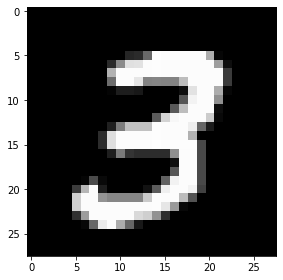

In [ ]:
#taken one image from mnist dataset
from skimage import io
io.imshow(my_image)
io.show()

In [ ]:
# transform image into patches of 8 X 8
from sklearn.feature_extraction.image import extract_patches_2d
patches = extract_patches_2d(my_image, (8, 8))
patches.shape

(441, 8, 8)

In [ ]:
# 1st patch of taken image
patches[0]

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# transform 2d patches array to 1d array
import numpy as np

patches = patches.reshape((len(patches), np.prod(patches.shape[1:])))
patches.shape

(441, 64)

In [ ]:
# fit
autoencoder.fit(patches, patches,
                epochs=epochs,
                shuffle=True)

Epoch 1/500
14/14 [==============================] - 7s 2ms/step - loss: 1.1291
Epoch 2/500
14/14 [==============================] - 0s 2ms/step - loss: 0.9279
Epoch 3/500
14/14 [==============================] - 0s 2ms/step - loss: 0.8428
Epoch 4/500
14/14 [==============================] - 0s 2ms/step - loss: 0.8067
Epoch 5/500
14/14 [==============================] - 0s 2ms/step - loss: 0.7870
Epoch 6/500
14/14 [==============================] - 0s 2ms/step - loss: 0.7724
Epoch 7/500
14/14 [==============================] - 0s 2ms/step - loss: 0.7618
Epoch 8/500
14/14 [==============================] - 0s 2ms/step - loss: 0.7519
Epoch 9/500
14/14 [==============================] - 0s 2ms/step - loss: 0.7358
Epoch 10/500
14/14 [==============================] - 0s 1ms/step - loss: 0.7331
Epoch 11/500
14/14 [==============================] - 0s 2ms/step - loss: 0.7223
Epoch 12/500
14/14 [==============================] - 0s 2ms/step - loss: 0.7127
Epoch 13/500
14/14 [=================

14/14 [==============================] - 0s 1ms/step - loss: 0.3438
Epoch 103/500
14/14 [==============================] - 0s 1ms/step - loss: 0.3449
Epoch 104/500
14/14 [==============================] - 0s 1ms/step - loss: 0.3532
Epoch 105/500
14/14 [==============================] - 0s 1ms/step - loss: 0.3328
Epoch 106/500
14/14 [==============================] - 0s 2ms/step - loss: 0.3338
Epoch 107/500
14/14 [==============================] - 0s 1ms/step - loss: 0.3426
Epoch 108/500
14/14 [==============================] - 0s 1ms/step - loss: 0.3347
Epoch 109/500
14/14 [==============================] - 0s 1ms/step - loss: 0.3340
Epoch 110/500
14/14 [==============================] - 0s 1ms/step - loss: 0.3319
Epoch 111/500
14/14 [==============================] - 0s 1ms/step - loss: 0.3429
Epoch 112/500
14/14 [==============================] - 0s 1ms/step - loss: 0.3261
Epoch 113/500
14/14 [==============================] - 0s 2ms/step - loss: 0.3320
Epoch 114/500
14/14 [=========

14/14 [==============================] - 0s 1ms/step - loss: 0.2613
Epoch 203/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2654
Epoch 204/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2532
Epoch 205/500
14/14 [==============================] - 0s 1ms/step - loss: 0.2555
Epoch 206/500
14/14 [==============================] - 0s 1ms/step - loss: 0.2599
Epoch 207/500
14/14 [==============================] - 0s 1ms/step - loss: 0.2587
Epoch 208/500
14/14 [==============================] - 0s 1ms/step - loss: 0.2555
Epoch 209/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2558
Epoch 210/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2567
Epoch 211/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2519
Epoch 212/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2585
Epoch 213/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2681
Epoch 214/500
14/14 [=========

14/14 [==============================] - 0s 1ms/step - loss: 0.2201
Epoch 303/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2236
Epoch 304/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2239
Epoch 305/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2180
Epoch 306/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2208
Epoch 307/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2226
Epoch 308/500
14/14 [==============================] - 0s 1ms/step - loss: 0.2232
Epoch 309/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2211
Epoch 310/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2187
Epoch 311/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2187
Epoch 312/500
14/14 [==============================] - 0s 1ms/step - loss: 0.2151
Epoch 313/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2205
Epoch 314/500
14/14 [=========

14/14 [==============================] - 0s 1ms/step - loss: 0.1959
Epoch 403/500
14/14 [==============================] - 0s 2ms/step - loss: 0.1994
Epoch 404/500
14/14 [==============================] - 0s 1ms/step - loss: 0.2044
Epoch 405/500
14/14 [==============================] - 0s 1ms/step - loss: 0.1983
Epoch 406/500
14/14 [==============================] - 0s 1ms/step - loss: 0.1978
Epoch 407/500
14/14 [==============================] - 0s 2ms/step - loss: 0.1997
Epoch 408/500
14/14 [==============================] - 0s 1ms/step - loss: 0.1959
Epoch 409/500
14/14 [==============================] - 0s 2ms/step - loss: 0.1888
Epoch 410/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2046
Epoch 411/500
14/14 [==============================] - 0s 2ms/step - loss: 0.2002
Epoch 412/500
14/14 [==============================] - 0s 1ms/step - loss: 0.1999
Epoch 413/500
14/14 [==============================] - 0s 2ms/step - loss: 0.1989
Epoch 414/500
14/14 [=========

In [ ]:
# prediction
pred_patches = autoencoder.predict(patches)

In [ ]:
# reshaping of patches from 1d to 2d
pred_patches = pred_patches.reshape(441,8,8)
pred_patches.shape

(441, 8, 8)

In [ ]:
# reconstruct predicted image patches to image
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
rec_image = reconstruct_from_patches_2d(pred_patches, (28, 28))

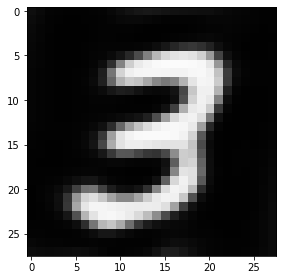

In [ ]:
# this is our sparse-autoencoder image
io.imshow(rec_image)
io.show()

In [ ]:
# pridiction from encoder
en_patches = encoder.predict(patches)
en_patches.shape

(441, 30)

In [ ]:
# We reshape pathces to 6 X 5 because encoder shape is 30 = 6 X 5
en_patches = en_patches.reshape(441,6,5)
en_patches.shape

(441, 6, 5)

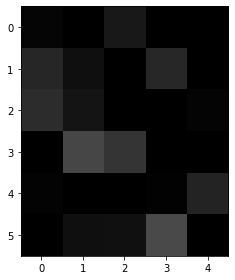

In [ ]:
# this is our 1st encoded patch i.e edge detector
io.imshow(en_patches[0])
io.show()

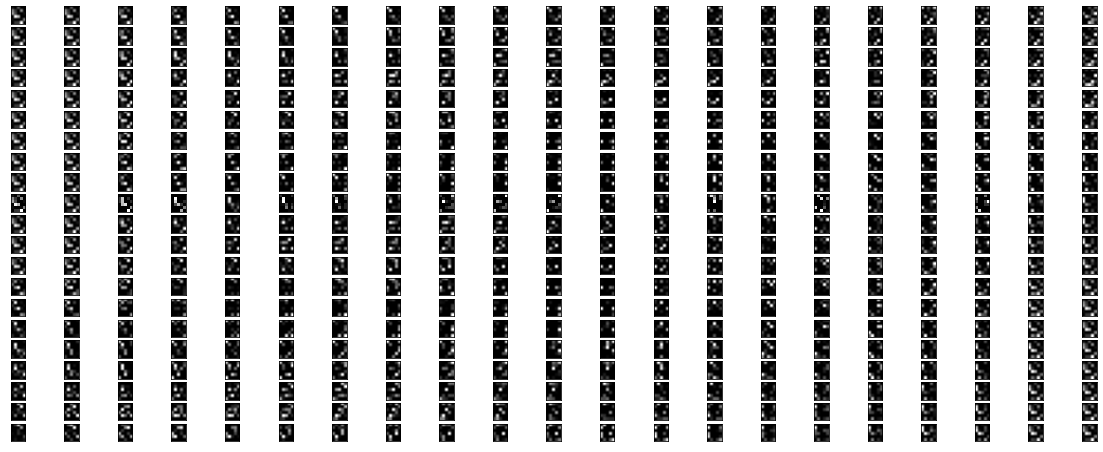

In [ ]:
# all edge dectors
from matplotlib import pyplot as plt
n = 441
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(21, 21, i)
    plt.imshow(en_patches[i-1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()